# The Data: Amazon and Google

## Let's Visualise the Data

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

data = pd.read_excel('Bloomberg Data.xlsx', engine='openpyxl', skiprows=9)
data['Dates'] = pd.to_datetime(data['Dates'])
data.set_index('Dates', inplace=True)

print(data.head(3))

            AMZN US Equity  GOOGL US Equity
Dates                                      
2004-08-18           39.36           85.000
2004-08-19           38.63          100.335
2004-08-20           39.51          108.310


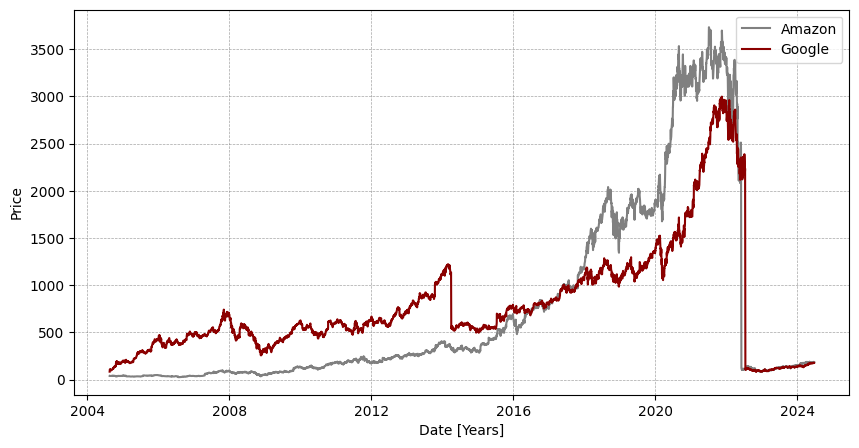

In [8]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(data['AMZN US Equity'], label='Amazon', color = "grey")
plt.plot(data['GOOGL US Equity'], label='Google', color = "darkred")

ax = plt.gca()
plt.xlabel('Date [Years]')
plt.ylabel('Price')
plt.legend()
plt.savefig('AmazonGoogle.png')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.show()

## Parameter estimation

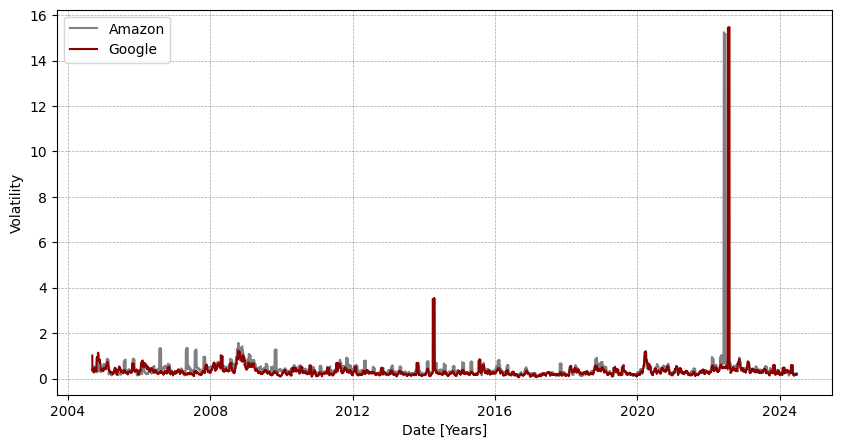

In [10]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

returns = np.log(data/data.shift(1)).dropna()                # daily log returns.
volatility = returns.rolling(window=14).std() * np.sqrt(365) # rolling volatility (14-day window) and we annualise it.

volatility.dropna(inplace=True)
S  = data.iloc[14:].values.T
V  = volatility.values.T
dt = 1/365

plt.style.use('default')
plt.figure(figsize=(10, 5))

plt.plot(volatility['AMZN US Equity'], label='Amazon', color = "grey")
plt.plot(volatility['GOOGL US Equity'], label='Google', color = "darkred")
plt.xlabel('Date [Years]')
ax = plt.gca()
plt.ylabel('Volatility')
plt.legend(['Amazon', 'Google'])
plt.savefig('Volatility.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.show()

In [11]:
# The True covariance matrix.
X = pd.DataFrame(np.array([S[0, ], S[1, ], V[0, ], V[1, ]])).T
X.columns = ['S1', 'S2', 'V1', 'V2']
corr_matrix = X.corr()
corr_matrix

,S1,S2,V1,V2
S1,1.000000,0.893323,-0.073473,-0.050406
S2,0.893323,1.000000,0.078795,-0.084205
V1,-0.073473,0.078795,1.000000,0.049386
V2,-0.050406,-0.084205,0.049386,1.000000


In [12]:
def log_likelihood(params, X, dt):
    """
    Calculates the log-likelihood for a multivariate stochastic model.
    Args:
      params: Vector of the parameters (11 in total).
      X:      Data frame containing the two stocks (S1, S2) and the volatilities (V1, V2).
      dt:     Time step.
    Returns:
      The negative log-likelihood.
    """
    mu1, mu2, k1, k2, theta1, theta2, xi1, xi2, rho_ss, rho_sv1, rho_sv2 = params
    S1 = X["S1"]
    S2 = X["S2"]
    V1 = X["V1"]
    V2 = X["V2"]
    n = len(X) - 1

    log_likelihood_val = 0

    for t in range(1, n + 1):
        mt = np.array([S1[t - 1] + mu1 * S1[t - 1] * dt,
                      S2[t - 1] + mu2 * S2[t - 1] * dt,
                      V1[t - 1] + k1 * (theta1 - V1[t - 1]) * dt,
                      V2[t - 1] + k2 * (theta2 - V2[t - 1]) * dt])

        sigmat = np.array([[(V1[t-1]*S1[t-1])**2*dt, V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0],
                          [V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, (V2[t-1]*S2[t-1])**2*dt, 0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt],
                          [V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0, (xi1*V1[t-1])**2*dt, 0],
                          [0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt, 0, (xi2*V2[t-1])**2*dt]])

        xt = np.array(X.iloc[t, :])
        try:
            term = np.dot((xt - mt).T, np.linalg.solve(sigmat, xt - mt))
            log_likelihood_val += -2 * n * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigmat)) - 0.5 * term
        except np.linalg.LinAlgError:
            # Might experience numerical issues with the covariance matrix here!
            return np.inf

    return log_likelihood_val

# Contrainst 1. Feller Condition 2. Cov Matrix should be PD 3. The bounds on the Parameters.
def feller_condition(params):
    """
    Ensure Feller condition 2k_i * theta_i > xi_i^2 for i = 1, 2.
    """
    _, _, k1, k2, theta1, theta2, xi1, xi2, _, _, _ = params
    return np.array([2 * k1 * theta1 - xi1**2, 2 * k2 * theta2 - xi2**2]) - 1e-6

def covariance_positive_definite(params, X, dt):
    """
    Ensure covariance matrix is positive definite by checking the eigenvalues for all time steps.
    """
    mu1, mu2, k1, k2, theta1, theta2, xi1, xi2, rho_ss, rho_sv1, rho_sv2 = params
    S1 = X["S1"]
    S2 = X["S2"]
    V1 = X["V1"]
    V2 = X["V2"]
    n = len(X) - 1

    eigenvalues_list = []

    for t in range(1, n + 1):
        sigmat = np.array([
            [(V1[t-1]*S1[t-1])**2*dt, V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0],
            [V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, (V2[t-1]*S2[t-1])**2*dt, 0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt],
            [V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0, (xi1*V1[t-1])**2*dt, 0],
            [0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt, 0, (xi2*V2[t-1])**2*dt]
        ])
        eigenvalues = np.linalg.eigvals(sigmat)
        eigenvalues_list.extend(eigenvalues)

    return np.array(eigenvalues_list) - 1e-6

bounds = [(0, 1),            # mu1
          (0, 1),            # mu2
          (0, 5),            # k1 (lower bound: 0)
          (0, 5),            # k2 (lower bound: 0)
          (0, 1),            # theta1 (no bounds)
          (0, 1),            # theta2 (no bounds)
          (0.00001, 1),      # xi1 (lower bound: 0)
          (0.00001, 1),      # xi2 (lower bound: 0)
          (-0.95, 0.95),     # rho_ss (bounds between -1 and 1 for correlation)
          (-0.95, 0.95),     # rho_sv1 (bounds between -1 and 1 for correlation)
          (-0.95, 0.95)]     # rho_sv2 (bounds between -1 and 1 for correlation)

cov_constraint = NonlinearConstraint(lambda params: covariance_positive_definite(params, X, dt), 0, np.inf)
feller_constraint = NonlinearConstraint(feller_condition, 0, np.inf)

In [ ]:
# Perform the optimisation using different initial parameter values and ensure that
# they all satisfy the conditions.

np.random.seed(10)#45
def generate_valid_initial_guess():
    """
    Returns: a valid initial guess for the parameters.
    """
    initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])
    while np.any(feller_condition(initial_guess) < 0) or np.any(covariance_positive_definite(initial_guess, X, dt) < 0):
        initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])
    return initial_guess

num_trials = 5
results = []

for i in range(num_trials):
    initial_guess = generate_valid_initial_guess()

    result = minimize(lambda params: -log_likelihood(params, X, dt),
                      initial_guess,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=[cov_constraint, feller_constraint])

    results.append(result)

In [342]:
all_vars = []
all_fun_vals = []

for i in range(num_trials):
    all_vars.append(results[i].x)  
    all_fun_vals.append(results[i].fun)  

resultsdf = pd.DataFrame(np.array(all_vars), 
                         index=[str(i+1) for i in range(num_trials)], 
                         columns=["mu1", "mu2", "k1", "k2", "theta1", "theta2", "xi1", "xi2", "rho_ss", "rho_sv1", "rho_sv2"])

fun_vals = pd.DataFrame(np.array(all_fun_vals), 
                        index=[str(i+1) for i in range(num_trials)], 
                        columns=["Log-likelihood Value"])

ParamEstimation = pd.concat([fun_vals, resultsdf], axis=1)
ParamEstimation.to_excel('ParamEstimation.xlsx', index=False)


In [343]:
ParamEstimation = pd.read_excel('ParamEstimation.xlsx')
np.round(ParamEstimation, decimals = 2)

,Log-likelihood Value,mu1,mu2,k1,k2,theta1,theta2,xi1,xi2,rho_ss,rho_sv1,rho_sv2
0,99409803.02,0.93,0.74,3.18,3.39,0.43,0.38,0.67,0.50,-0.32,0.04,0.04
1,98898161.21,0.04,0.14,4.93,3.08,0.44,0.44,0.57,0.73,0.24,-0.03,-0.00
2,99709277.16,0.22,0.26,4.46,2.13,0.20,0.51,0.78,0.42,0.79,-0.02,-0.02
3,98693460.85,0.85,0.85,4.97,1.08,0.81,0.37,0.66,0.85,-0.78,-0.01,-0.02
4,98870468.29,0.82,0.88,0.76,4.48,0.94,0.51,0.86,0.63,0.16,0.03,-0.02


# Simulate Paths

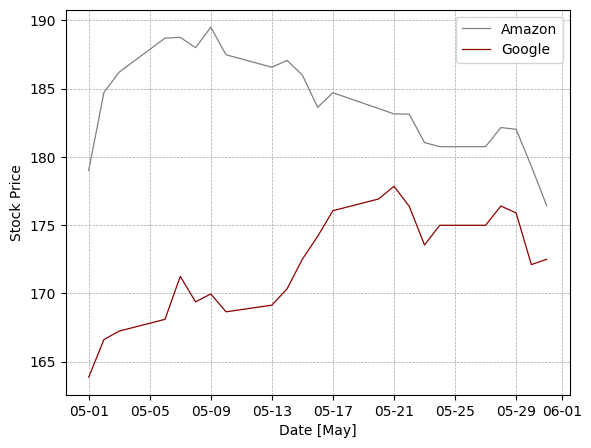

In [344]:
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter

end_date   = datetime(2024, 5, 31)          # Get May Stock Prices.
start_date = end_date - timedelta(days=30)
may_data   = data.loc[start_date:end_date]

plt.style.use('default')
plt.figure(figsize=(6.5, 5))
plt.plot(may_data.index, may_data['AMZN US Equity'], label='Amazon', color = "grey", linewidth = 0.9)
plt.plot(may_data.index, may_data['GOOGL US Equity'], label='Google', color = "darkred", linewidth = 0.9)
plt.xlabel('Date [May]')
plt.ylabel('Stock Price')
date_form = DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
ax = plt.gca()
plt.legend()
plt.savefig('MayPrices.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.show()

In [ ]:
max_index      = ParamEstimation["Log-likelihood Value"].idxmax()
optimal_params = ParamEstimation.loc[max_index]

S1_31 = may_data.iloc[-1, 0] # Amazon 2024-05-31.
S2_31 = may_data.iloc[-1, 1] # Google 2024-05-31.
V1_31 = volatility.iloc[-1, 0]
V2_31 = volatility.iloc[-1, 1]
n  = 30                   # June has 30 days.
dt = 1/365                # Time step size.

mu    = np.array([optimal_params[1:3]])
kappa = np.array([optimal_params[4:6]])
theta = np.array([optimal_params[6:8]])
xi    = np.array([optimal_params[8:10]])

rho_ss  = optimal_params[9]
rho_sv1 = optimal_params[10]
rho_sv2 = optimal_params[11]

corr_matrix = np.array([[1       , rho_ss  , rho_sv1,  0     ],
                        [rho_ss  , 1       , 0      , rho_sv2],
                        [rho_sv1 , 0       , 1      , 0      ],
                        [0       , rho_sv2 , 0      , 1      ]])

In [351]:
def simulate_paths(n, S1, S2, V1, V2, corr_matrix, mu, kappa, theta, xi, dt):
    """
    Simulate paths for two stock prices and their volatilities using Euler discretization.

    Parameters:
    - n: Number of time steps (T - Time to maturity).
    - S1 & S2: Initial prices.
    - V1 & V2: Initial volatilities.
    - corr_matrix: Correlation matrix.
    - mu: Risk-free interest rate.
    - kappa: Mean-reversion rates for the volatilities.
    - theta: Long-term mean volatilities.
    - xi: Volatility of volatilities.
    - dt: Time step size.

    Returns:
    - S1_sim: Simulated paths for the first stock.
    - S2_sim: Simulated paths for the second stock.
    - tau: Time to maturity.
    """
    S1_sim = np.zeros((n+1,))
    S2_sim = np.zeros((n+1,))
    tau = np.zeros((n+1,))

    SSim = np.zeros((n+1, 2))
    VSim = np.zeros((n+1, 2))

    SSim[0, 0] = S1
    SSim[0, 1] = S2
    VSim[0, :] = [V1, V2]
    T = n
    tau[0] = T


    Z = np.random.randn(n, 4)

    C = np.linalg.cholesky(corr_matrix)
    Z_correlated = np.matmul(C, Z.T).T

    for i in range(n):
        dS = mu * SSim[i, :] * dt + np.sqrt(VSim[i, :]) * SSim[i, :] * np.sqrt(dt) * Z_correlated[i, 1:3]
        dV = kappa * (theta - VSim[i, :]) * dt + xi * np.sqrt(VSim[i, :]) * np.sqrt(dt) * Z_correlated[i, 3:]

        SSim[i+1, :] = SSim[i, :] + dS
        VSim[i+1, :] = VSim[i, :] + dV
        tau[i+1] = T - (i+1)

    S1_sim = SSim[:, 0]
    S2_sim = SSim[:, 1]

    return S1_sim, S2_sim, tau/365 # annualise time to maturity

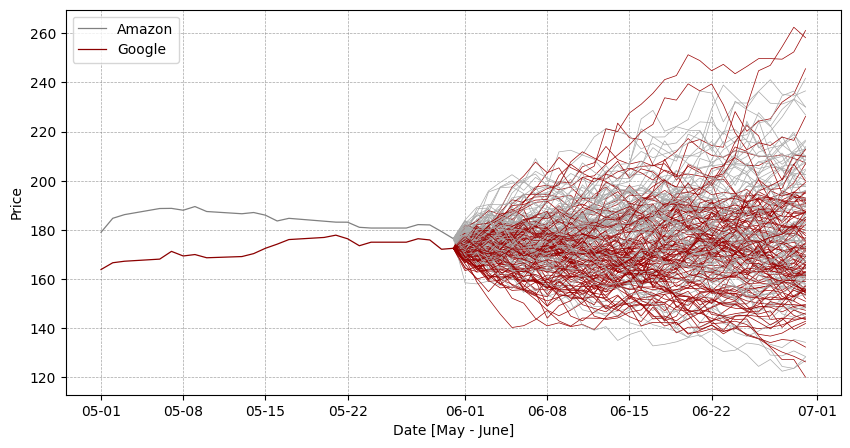

In [352]:
start_date = datetime(2024, 5, 31)
simulated_dates = [start_date + timedelta(days=i) for i in range(31)] # June.

plt.figure(figsize=(10, 5))
plt.style.use('default')
plt.plot(may_data['AMZN US Equity'], label = 'Amazon', color = "grey", linewidth = 0.9)
plt.plot(may_data['GOOGL US Equity'], label = 'Google', color = "darkred", linewidth = 0.9)

# Simulate a hundred paths
numpaths = 100
paths = [simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt) for i in range(numpaths)]

for path in paths:
    plt.plot(simulated_dates, path[0], linewidth = 0.5, color = "#A9A9A9")
    plt.plot(simulated_dates, path[1], linewidth = 0.5, color = "#990000")

plt.xlabel('Date [May - June]')
plt.ylabel('Price')
date_form = DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.legend(['Amazon', 'Google'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.savefig('JuneSimulatedPrices.png')

# Black-Scholes Hedge

In [353]:
from scipy.stats import norm

def payoff(path):   # To get the payoff HT
  difference = path[0] - path[1]
  return np.maximum(difference, 0)

def Phi(x):
    return norm.cdf(x)

def d1(St, Tt, sigmas, rho):
    S = St[0] / St[1]
    cov = np.prod(sigmas) * rho
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d1 = (np.log(S) + 0.5 * Tt * sig ** 2) / (sig * np.sqrt(Tt))
    return _d1

def d2(St, Tt, sigmas, rho):
    cov = np.prod(sigmas) * rho
    _d1 = d1(St, Tt, sigmas, rho)
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d2 = _d1 - sig * np.sqrt(Tt)
    return _d2

def price(path, Tt, sigmas, rho):
  price = path[0] * Phi(d1(path, Tt, sigmas, rho)) - path[1] * Phi(d2(path, Tt, sigmas, rho))
  return price

In [354]:
sigma = xi
rho   = rho_ss

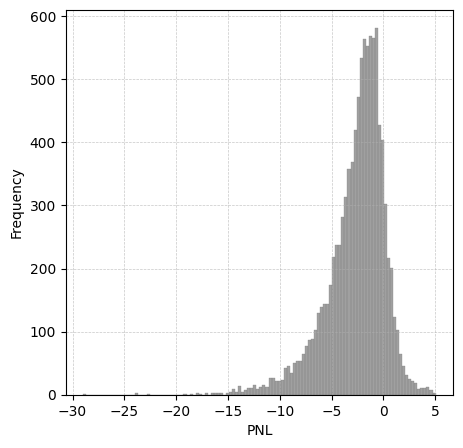

PNL BS Mean: -2.646, PNL BS Std: 2.873


In [355]:
import seaborn as sns

tau = paths[0][2]
PNL_BS = []
numpaths = 10000

paths = [simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt) for i in range(numpaths)]

for path_index, path in enumerate(paths):
    H = payoff(path)[-1]
    pathMat = np.column_stack((path[0], path[1]))
    V = price(pathMat[0], tau[0], sigma, rho)
    delta_S = np.diff(pathMat, axis=0)

    for i in range(len(delta_S)):
        Tt = tau[i]
        St = pathMat[i]
        phi1 = Phi(d1(St, Tt, sigma, rho))
        phi2 = -Phi(d2(St, Tt, sigma, rho))
        V += phi1 * delta_S[i, 0] + phi2 * delta_S[i, 1]

    pnl = V - H
    PNL_BS.append(pnl)

plt.figure(figsize=(5, 5))
sns.histplot(PNL_BS, color = "grey", edgecolor = "grey")
plt.xlabel('PNL')
plt.ylabel('Frequency')
plt.savefig('ProfitLossBS.png')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
print(f'PNL BS Mean: {np.mean(PNL_BS):.3f}, PNL BS Std: {np.std(PNL_BS):.3f}')

# Neural Network Hedge

## Data Preparation - Train and Validation Data

In [136]:
# Separate into Training and Test Data!!!
from tqdm import tqdm
import torch
import copy

def prepare_data(numpaths, simulate_fn, sigma, rho):
  Stocks = []
  Prices = []
  for _ in tqdm(range(numpaths), desc = f'Simulating Paths {numpaths}'):
    path = simulate_fn()
    H = payoff(path)[-1]
    tau = path[2]
    pathmatrix = np.column_stack((path[0], path[1]))
    Ht = [price(pathmatrix[i], tau[i], sigma, rho) for i in range(len(path[0]) - 1)]
    Ht.append(H)

    S1 = torch.tensor(path[0], dtype=torch.float32).reshape(-1, 1)
    S2 = torch.tensor(path[1], dtype=torch.float32).reshape(-1, 1)
    Tau = torch.tensor(tau, dtype=torch.float32).reshape(-1, 1)
    Ht = torch.tensor(Ht, dtype=torch.float32).reshape(-1, 1)
    inputs = torch.cat((S1, S2, Tau), dim=1)

    Stocks.append(inputs)
    Prices.append(Ht)

  return Stocks, Prices   

In [373]:
numpaths = 1000
train_data, train_labels = prepare_data(numpaths,
                                        lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                        sigma, rho)
valid_data, valid_labels = prepare_data(numpaths,
                                      lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                      sigma, rho) 

Simulating Paths 1000: 100%|██████████| 1000/1000 [00:05<00:00, 188.08it/s]


## Hyperparameter Tuning

In [360]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class HedgingNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(HedgingNet, self).__init__()
        self.layers = nn.ModuleList()
    
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.activation_fn = activation_fn

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = getattr(F, self.activation_fn[i])(layer(x))
        x = torch.tanh(self.layers[-1](x))  # Final layer activation
        return x

def regularization_loss(model, reg_type, lambda_reg): # regularisation
    reg_loss = 0.0
    if reg_type == 'l1':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(torch.abs(param))
    elif reg_type == 'l2':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(param ** 2)
    return lambda_reg * reg_loss

def custom_loss(one_day_pl, delta_Ht, model, reg_type, lambda_reg):
    oneDayPL = torch.stack(one_day_pl).unsqueeze(1)
    mse_loss = F.mse_loss(oneDayPL, delta_Ht)
    reg_loss = regularization_loss(model, reg_type, lambda_reg)
    total_loss = mse_loss + reg_loss
    
    return total_loss

input_size  = 3
output_size = 2
learning_rate = 0.001
epochs = 2500

In [ ]:
import optuna
from copy import copy

def objective(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 6)  # Tune number of hidden layers
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 100, 500) for i in range(num_hidden_layers)]

    activation_fn = [trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh']) for i in range(num_hidden_layers)]
    
    lambda_reg = trial.suggest_float('lambda_reg', 0.0, 1.0)
    reg_type   = trial.suggest_categorical('reg_type', ['l1', 'l2'])

    model = HedgingNet(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, activation_fn=activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    best_loss = float('inf')
    train_losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        epoch_losses = []

        for i in range(len(train_data)):
            inputs = train_data[i]
            Ht = train_labels[i]

            optimizer.zero_grad()
            outputs = model(inputs)
            phi1, phi2 = outputs[:, 0], outputs[:, 1]

            pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
            tau = inputs[:, 2].detach().numpy()
            V = price(pathmatrix[0], tau[0], sigma, rho)  
            one_day_PL = []

            for t in range(1, len(inputs)):
                delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
                delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
                V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
                one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

            delta_Ht = Ht[1:] - Ht[:-1]
            loss = custom_loss(one_day_PL, delta_Ht, model, reg_type, lambda_reg)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        average_loss = np.mean(epoch_losses)
        train_losses.append(average_loss)

        if  average_loss < best_loss:
            best_loss = average_loss
            best_model = copy.deepcopy(model)

        scheduler.step(average_loss)

    return best_loss

study = optuna.create_study(study_name='Hyperparameter Tuning', direction='minimize')

no_trials = 10

with tqdm(total=no_trials, desc='Optuna Trials') as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=no_trials, callbacks=[callback])


In [363]:
best_trial = study.best_trial
best_hidden_sizes = [best_trial.params[f'hidden_size_{i}'] for i in range(best_trial.params['num_hidden_layers'])]
best_lambda_reg = best_trial.params['lambda_reg']
best_reg_type = best_trial.params['reg_type']

best_activation_fn = [best_trial.params[f'activation_{i}'] for i in range(best_trial.params['num_hidden_layers'])]

In [364]:
best_activation_fn = ['sigmoid', 'relu', 'sigmoid']
best_hidden_sizes  = [486, 479, 404]
best_lambda_reg    = 0.07213871432969199
best_reg_type      = 'l2'

In [365]:
model = HedgingNet(input_size=input_size, hidden_sizes=best_hidden_sizes, output_size=output_size, activation_fn=best_activation_fn)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print('Activation functions (variable): ', best_activation_fn)
print('Hidden Sizes:                    ', best_hidden_sizes)
print('Regularisation Type:             ', best_reg_type)
print('Regularisation Value:            ', best_lambda_reg)

model.eval()


Activation functions (variable):  ['sigmoid', 'relu', 'sigmoid']
Hidden Sizes:                     [486, 479, 404]
Regularisation Type:              l2
Regularisation Value:             0.07213871432969199


HedgingNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=486, bias=True)
    (1): Linear(in_features=486, out_features=479, bias=True)
    (2): Linear(in_features=479, out_features=404, bias=True)
    (3): Linear(in_features=404, out_features=2, bias=True)
  )
)

## Train the Best Network from the Tuning

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

best_loss = float('inf')
best_model = None
best_pnl_std = float('inf')

train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs), desc="Learning!!!"):
    model.train()
    epoch_PNL_train = []
    epoch_losses    = []

    # Training phase
    for i in range(len(train_data)):
        inputs = train_data[i]
        Ht = train_labels[i]

        optimizer.zero_grad()
        outputs = model(inputs)
        phi1, phi2 = outputs[:, 0], outputs[:, 1]

        pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
        tau = inputs[:, 2].detach().numpy()
        V = price(pathmatrix[0], tau[0], sigma, rho)
        one_day_PL = []

        for t in range(1, len(inputs)):
            delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
            delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
            V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
            one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

        pnl = V - Ht[-1]
        epoch_PNL_train.append(pnl.item())

        delta_Ht = Ht[1:] - Ht[:-1]
        loss = custom_loss(one_day_PL, delta_Ht, model, best_reg_type, 0)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_train_loss = np.mean(epoch_losses)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    valid_losses_epoch = []
    epoch_PNL_valid = []
    with torch.no_grad():
        for i in range(len(valid_data)):
            inputs = valid_data[i]
            Ht = valid_labels[i]

            outputs = model(inputs)
            phi1, phi2 = outputs[:, 0], outputs[:, 1]

            pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
            tau = inputs[:, 2].detach().numpy()
            V = price(pathmatrix[0], tau[0], sigma, rho)
            one_day_PL = []

            for t in range(1, len(inputs)):
                delta_S1 = (inputs[t, 0] - inputs[t - 1, 0]).squeeze()
                delta_S2 = (inputs[t, 1] - inputs[t - 1, 1]).squeeze()
                V += phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2
                one_day_PL.append(phi1[t - 1] * delta_S1 + phi2[t - 1] * delta_S2)

            pnl = V - Ht[-1]
            epoch_PNL_valid.append(pnl.item())

            delta_Ht = Ht[1:] - Ht[:-1]
            valid_loss = custom_loss(one_day_PL, delta_Ht, model, best_reg_type, 0)
            valid_losses_epoch.append(valid_loss.item())

    average_valid_loss = np.mean(valid_losses_epoch)
    valid_losses.append(average_valid_loss)

    scheduler.step(average_train_loss)
    current_lr = scheduler.get_last_lr()[0]

    print('\n')
    print(f'Learning Rate: {current_lr}')

    pnl_mean = np.mean(epoch_PNL_valid)
    pnl_std = np.std(epoch_PNL_valid)
    print(f"Train Loss: {average_train_loss:.6f} | Valid Loss: {average_valid_loss:.6f} | PNL Mean: {pnl_mean:.3f}, PNL Std: {pnl_std:.3f}")

    if average_valid_loss < best_loss:  # Pocket the best model when the validation loss improves
        best_loss = average_valid_loss
        best_model = copy.deepcopy(model)



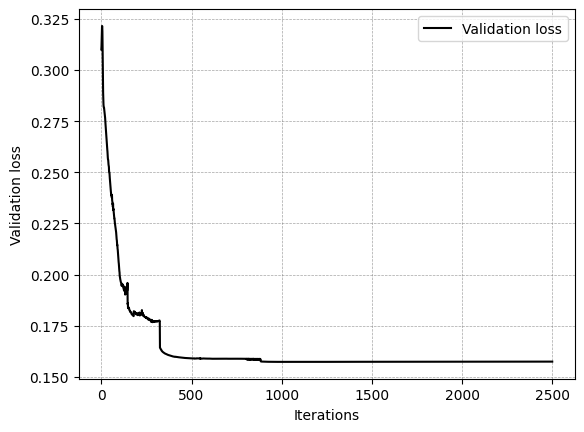

In [368]:
import seaborn as sns

sns.lineplot(valid_losses, color = 'black', label = 'Validation loss')
plt.ylabel('Validation loss')
plt.xlabel('Iterations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.savefig('Validation loss')
plt.show()


In [369]:
print(best_model)

HedgingNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=486, bias=True)
    (1): Linear(in_features=486, out_features=479, bias=True)
    (2): Linear(in_features=479, out_features=404, bias=True)
    (3): Linear(in_features=404, out_features=2, bias=True)
  )
)


In [370]:
# torch.save(best_model.state_dict(), 'best_model.pth')

In [371]:
hedgeNN = HedgingNet(input_size=3, hidden_sizes=best_hidden_sizes, output_size=2, activation_fn=best_activation_fn)
hedgeNN.load_state_dict(torch.load('best_model.pth'))
hedgeNN.eval()

C:\Users\Student\AppData\Local\Temp\ipykernel_15992\1581864450.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hedgeNN.load_state_dict(torch.load('best_model.pth'))


HedgingNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=486, bias=True)
    (1): Linear(in_features=486, out_features=479, bias=True)
    (2): Linear(in_features=479, out_features=404, bias=True)
    (3): Linear(in_features=404, out_features=2, bias=True)
  )
)

### Test data to compare with Black-Scholes 

In [327]:
numpaths_test = 10000 # Finally to compare to Black-Scholes
test_data, test_labels = prepare_data(numpaths_test,
                                      lambda: simulate_paths(n, S1_31, S2_31, V1_31, V2_31, corr_matrix, mu, kappa, theta, xi, dt),
                                      sigma, rho)

Simulating Paths 10000: 100%|██████████| 10000/10000 [00:52<00:00, 190.15it/s]


In [375]:
# Fit on unseen data
PNL_NN = []
losses = []
for i in range(numpaths_test): # Using on Unseen Data and compare with BS Hedge!!!
    inputs = test_data[i]
    Ht     = test_labels[i]
    delta_Ht = Ht[1:] - Ht[:-1]
    with torch.no_grad():
        outputs = hedgeNN(inputs)
        phi1, phi2 = outputs[:, 0], outputs[:, 1]

        pathmatrix = np.column_stack((inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy()))
        tau = inputs[:, 2].detach().numpy()
        V = price(pathmatrix[0], tau[0], sigma, rho)
        one_day_PL = []
        for i in range(1, len(inputs)):
          delta_S1 = (inputs[i,0] - inputs[i-1,0]).squeeze()
          delta_S2 = (inputs[i,1] - inputs[i-1,1]).squeeze()
          V += phi1[i-1].item() * delta_S1 + phi2[i-1].item() * delta_S2
          one_day_PL.append(phi1[i-1].item() * delta_S1 + phi2[i-1].item() * delta_S2)

        loss = custom_loss(one_day_PL, delta_Ht, hedgeNN, best_reg_type, best_lambda_reg)
        losses.append(loss.item())

    average_loss = np.mean(losses)
    pnl = V - Ht[-1]
    PNL_NN.append(pnl.item())

print('PNL Mean:', np.mean(PNL_NN))
print('PNL Std: ', np.std(PNL_NN))


PNL Mean: -0.560175006041769
PNL Std:  2.187354099988716


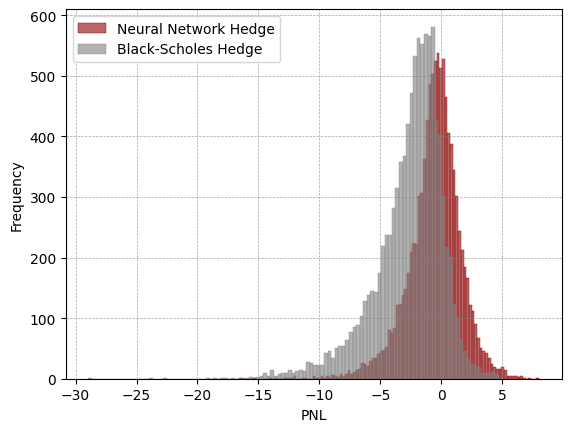

In [376]:
sns.histplot(PNL_NN, color="darkred", edgecolor="darkred", alpha=0.6, label="Neural Network Hedge")
sns.histplot(PNL_BS, color = "grey", edgecolor = "grey", alpha = 0.6, label = "Black-Scholes Hedge")
plt.xlabel('PNL')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color = 'grey')
plt.legend()
plt.savefig("sheesh.png")
plt.show()

In [377]:
print(f'PNL NN Mean: {np.mean(PNL_NN):.3f}, PNL NN Std: {np.std(PNL_NN):.3f}')
print(f'PNL BS Mean: {np.mean(PNL_BS):.3f}, PNL BS Std: {np.std(PNL_BS):.3f}')

PNL NN Mean: -0.560, PNL NN Std: 2.187
PNL BS Mean: -2.646, PNL BS Std: 2.873
